In [ ]:
import os
import shutil
import random
import zipfile

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

from google.colab import drive, auth
from google.cloud import storage

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'itsmegood'
os.environ['KAGGLE_KEY'] = '6361fc6e26d25239420ac9d1686c8354'

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
api.dataset_list_files('shayanriyaz/riceleafs').files

{}

In [ ]:
api.dataset_download_files('shayanriyaz/riceleafs', path=".")

In [ ]:
local_zip = './riceleafs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
source_path = '/tmp/RiceLeafs'

# train source
source_path_train_Brownspot = os.path.join(source_path, 'train/BrownSpot')
source_path_train_Healthy   = os.path.join(source_path, 'train/Healthy')
source_path_train_Hispa     = os.path.join(source_path, 'train/Hispa')
source_path_train_LeafBlast = os.path.join(source_path, 'train/LeafBlast')

# Validation source
source_path_validation_Brownspot  = os.path.join(source_path, 'validation/BrownSpot')
source_path_validation_Healthy    = os.path.join(source_path, 'validation/Healthy')
source_path_validation_Hispa      = os.path.join(source_path, 'validation/Hispa')
source_path_validation_LeafBlast  = os.path.join(source_path, 'validation/LeafBlast')

In [ ]:
train_healthy = os.listdir(source_path_train_Healthy)
train_remove = train_healthy[:700]

val_healthy = os.listdir(source_path_validation_Healthy)
val_remove = val_healthy[:150]

for files in train_remove:
  files_path = os.path.join(source_path_train_Healthy, files)
  os.remove(files_path)

for files in val_remove:
  files_path = os.path.join(source_path_validation_Healthy, files)
  os.remove(files_path)

In [ ]:
print(f"There are {len(os.listdir(source_path_train_Brownspot))} images of Train Brown Spot.")
print(f"There are {len(os.listdir(source_path_train_Healthy))} images of Train Healthy.")
print(f"There are {len(os.listdir(source_path_train_Hispa))} images of Train Hispa.")
print(f"There are {len(os.listdir(source_path_train_LeafBlast))} images of Train LeafBlast.\n")

print(f"There are {len(os.listdir(source_path_validation_Brownspot))} images of Validation Brown Spot.")
print(f"There are {len(os.listdir(source_path_validation_Healthy))} images of Validation Healthy.")
print(f"There are {len(os.listdir(source_path_validation_Hispa))} images of Validation Hispa.")
print(f"There are {len(os.listdir(source_path_validation_LeafBlast))} images of Validation LeafBlast.\n")

There are 418 images of Train Brown Spot.
There are 491 images of Train Healthy.
There are 452 images of Train Hispa.
There are 623 images of Train LeafBlast.

There are 105 images of Validation Brown Spot.
There are 147 images of Validation Healthy.
There are 113 images of Validation Hispa.
There are 156 images of Validation LeafBlast.



Sample Testing Healthy Rice Leaf:


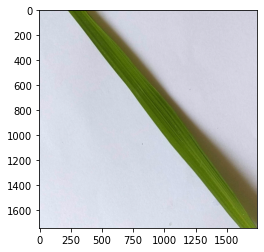

Sample Testing Hispa Rice Leaf:


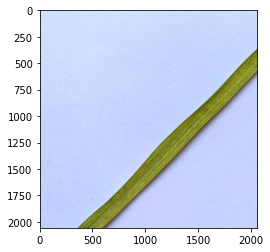

In [ ]:
random_number = random.randint(0, len(os.listdir(source_path_validation_Hispa)))
print("Sample Testing Healthy Rice Leaf:")
plt.imshow(load_img(f"{os.path.join(source_path_train_Healthy, os.listdir(source_path_train_Healthy)[random_number])}"))
plt.show()

print("Sample Testing Hispa Rice Leaf:")
plt.imshow(load_img(f"{os.path.join(source_path_train_LeafBlast , os.listdir(source_path_train_LeafBlast )[random_number])}"))
plt.show()

In [ ]:
TRAINING_DIR = os.path.join(source_path, 'train')
VALIDATION_DIR = os.path.join(source_path, 'validation')

In [ ]:
shape = (224, 224)

trainset = []
i = 0

for file in os.listdir(TRAINING_DIR):
  path = os.path.join(TRAINING_DIR, file)
  t    = 0
  for k in os.listdir(path):
    image    = load_img(os.path.join(path, k), grayscale=False, color_mode='rgb', target_size = shape)
    image    = img_to_array(image)
    image    = image/255.0
    trainset += [[image, i]]
    t        +=1
  i = i+1

In [ ]:
testset = []
ii = 0

for file in os.listdir(VALIDATION_DIR):
    path = os.path.join(VALIDATION_DIR,file)
    t    = 0
    for k in os.listdir(path):
        image    = load_img(os.path.join(path,k), grayscale=False, color_mode='rgb', target_size=shape)
        image    = img_to_array(image)
        image    = image/255.0
        testset  += [[image, ii]]
        t        += 1
    ii = ii+1

In [ ]:
data, trainlabels = zip(*trainset)
test, testlabels = zip(*testset)

labels1 = to_categorical(trainlabels)
labels  = np.array(labels1)

data    = np.array(data)
test    = np.array(test)

trainx, testx, trainy, testy = train_test_split(data,
                                                labels,
                                                test_size=0.2,
                                                random_state=42)

In [ ]:
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(1587, 224, 224, 3)
(397, 224, 224, 3)
(1587, 4)
(397, 4)


In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=30,
                             zoom_range=0.2,
                             width_shift_range=0.1,
                             height_shift_range=0.2,
                             shear_range=0.2)

In [ ]:
pretrained_model = tf.keras.applications.DenseNet201(input_shape=(224,224,3),
                                                     include_top=False,
                                                     weights='imagenet')

In [ ]:
inputs = pretrained_model.input
x = Dropout(0.5)(pretrained_model.output)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# !pip install -q -U keras-tuner

In [ ]:
# import keras_tuner as kt

In [ ]:
# def model_builder(hp):
#   model = tf.keras.Model(inputs=inputs, outputs=outputs)

#   hp_learning_rate = hp.Choice('learning_rate', values=[5e-3, 1e-4, 3e-4, 5e-4])

#   model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss = 'categorical_crossentropy',
#                 metrics = ['accuracy'])

#   return model

In [ ]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_accuracy',
#                      max_epochs=10,
#                      factor=3)

In [ ]:
# tuner.search(train_datagen.flow(trainx,trainy,batch_size=32),
#              validation_data=(testx,testy),
#              epochs=20,
#              callbacks=[stop_early])

# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
his=model.fit(train_datagen.flow(trainx,trainy,batch_size=32),
              validation_data=(testx,testy),
              epochs=20,
              verbose=1)

Epoch 1/40
50/50 [==============================] - 68s 714ms/step - loss: 2.0329 - accuracy: 0.4071 - val_loss: 2.1607 - val_accuracy: 0.3728
Epoch 2/40
50/50 [==============================] - 33s 654ms/step - loss: 1.6210 - accuracy: 0.5362 - val_loss: 2.7978 - val_accuracy: 0.3678
Epoch 3/40
50/50 [==============================] - 32s 634ms/step - loss: 1.4720 - accuracy: 0.5640 - val_loss: 1.8836 - val_accuracy: 0.5214
Epoch 4/40
50/50 [==============================] - 32s 639ms/step - loss: 1.4068 - accuracy: 0.5929 - val_loss: 3.1529 - val_accuracy: 0.4131
Epoch 5/40
50/50 [==============================] - 32s 638ms/step - loss: 1.2009 - accuracy: 0.6541 - val_loss: 1.3949 - val_accuracy: 0.6675
Epoch 6/40
50/50 [==============================] - 33s 651ms/step - loss: 1.1082 - accuracy: 0.6824 - val_loss: 1.2258 - val_accuracy: 0.6549
Epoch 7/40
50/50 [==============================] - 32s 641ms/step - loss: 1.1066 - accuracy: 0.6641 - val_loss: 1.2845 - val_accuracy: 0.6801

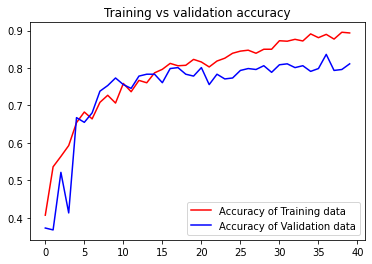

<Figure size 432x288 with 0 Axes>

In [ ]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

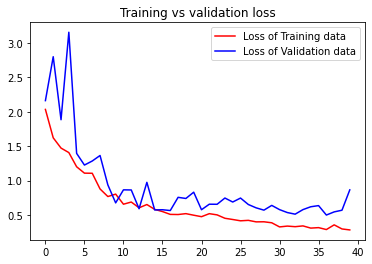

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
y_pred = model.predict(testx)
pred = np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75        92
           1       0.93      0.83      0.88       115
           2       0.78      0.76      0.77       112
           3       0.77      0.95      0.85        78

    accuracy                           0.81       397
   macro avg       0.81      0.82      0.81       397
weighted avg       0.82      0.81      0.81       397



In [ ]:
# export_dir = 'saved_model/1'
# tf.saved_model.save(model, export_dir)

In [ ]:
# Select mode of optimization
# mode = "normal" 

# if mode == 'Storage':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
# elif mode == 'Speed':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
# else:
#     optimization = tf.lite.Optimize.DEFAULT

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpobq3bbty/assets


In [ ]:
model.save('tmp/rice-leaf-disease-prediction.h5')

In [ ]:
auth.authenticate_user()

project_id = '[modular-seeker-344111]'
!gcloud config set project {project_id}

In [ ]:
bucket_name = 'c22-pc379'

!gsutil mb gs://{bucket_name}

!gsutil cp /tmp/tmpobq3bbty/assets/model.tflite gs://{bucket_name}/

!gsutil cat gs://{bucket_name}//tmp/tmpobq3bbty/assets/model.tflite

In [ ]:
drive.mount('/content/drive')

In [ ]:
h5_path = '/tmp/rice-leaf-disease-prediction.h5'
tflite_path = '/tmp/tmpobq3bbty/assets/model.tflite'
destination = '/content/drive/MyDrive/RiceDiseaseDetection'

shutil.copy([h5_path, tflite_path], destination)